In [1]:
#Step 1: Get Tesla prices (X)
#Step 1 B: Explore data (what will data will be taken into consideration for our model? what data is important?) (X)
# ---- volume and closing price 
#Step 1 C: Save the data into a csv to prevent running into exceeding API limits (X)
#Step 2: Determine how many days i want to predict the closing price (X)
#Step 2 B: Clean data (X)
#Step 2 C: Explore data (X)
#Step 3: Determine model that will be used ()
#Step 3 B: Determine metrics to judge model performance ()
# Step 4: Split data into testing and training (validation part of training set) ()
#Step 5: Train the model ()
#Step 6: Use validation set to determine hyperparameters ()
#Step 7: Test Model ()
#Step 8: Deploy model, Save parameters ()

# Import 

In [2]:
pip install alpha_vantage

     |████████████████████████████████| 1.1 MB 30.4 MB/s 
     |████████████████████████████████| 160 kB 41.5 MB/s 
     |████████████████████████████████| 192 kB 43.1 MB/s 
     |████████████████████████████████| 271 kB 39.1 MB/s 


## Introduction to Data

In [3]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv

In [4]:
key = 'A7VBYOS5Q7SUYXRW'
ts = TimeSeries(key, output_format='pandas')
data,meta = ts.get_daily('TSLA', outputsize='full')
data

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2021-12-17,914.77,960.6599,909.0401,932.57,33626754.0
2021-12-16,994.50,994.9800,921.8500,926.92,27590483.0
2021-12-15,953.21,978.7499,928.2501,975.99,25056410.0
2021-12-14,945.00,966.4100,930.0000,958.51,23602090.0
2021-12-13,1001.09,1005.0000,951.4200,966.41,26198502.0
...,...,...,...,...,...
2010-07-06,20.00,20.0000,15.8300,16.11,6866900.0
2010-07-02,23.00,23.1000,18.7100,19.20,5139800.0
2010-07-01,25.00,25.9200,20.2700,21.96,8218800.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2890 entries, 2021-12-17 to 2010-06-29
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   1. open    2890 non-null   float64
 1   2. high    2890 non-null   float64
 2   3. low     2890 non-null   float64
 3   4. close   2890 non-null   float64
 4   5. volume  2890 non-null   float64
dtypes: float64(5)
memory usage: 135.5 KB


In [6]:
data.columns

Index(['1. open', '2. high', '3. low', '4. close', '5. volume'], dtype='object')

In [7]:
data.describe()

,1. open,2. high,3. low,4. close,5. volume
count,2890.000000,2890.000000,2890.000000,2890.000000,2.890000e+03
mean,285.197958,291.206265,278.956791,285.390203,9.420474e+06
std,279.817660,287.402472,272.128121,280.342572,1.290526e+07
min,16.140000,16.630000,14.980000,15.800000,1.185000e+05
25%,81.192500,87.160000,78.370250,83.640500,2.581337e+06
50%,230.570000,234.670000,226.960000,230.465000,5.501000e+06
75%,332.472500,338.330000,326.500000,333.025000,1.040948e+07
max,2295.120000,2318.490000,2186.520000,2238.750000,2.221262e+08


**Notes**

- Data goes back to 2010
- No null values 
- Date is an index, not a column
- Might have to change data data type

## Cleaning 

In [8]:
clean_data = data.reindex(index=data.index[::-1])
clean_data = clean_data.rename({'1. open': 'open', '2. high':'high', '3. low':'low','4. close':'close' ,'5. volume':'volume'}, axis = 1)
clean_data['volume'] = clean_data['volume'].astype(float).astype(int)
clean_data.head()

,open,high,low,close,volume
date,,,,,
2010-06-29,19.00,25.0000,17.54,23.89,18766300
2010-06-30,25.79,30.4192,23.30,23.83,17187100
2010-07-01,25.00,25.9200,20.27,21.96,8218800
2010-07-02,23.00,23.1000,18.71,19.20,5139800
2010-07-06,20.00,20.0000,15.83,16.11,6866900


In [9]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2890 entries, 2010-06-29 to 2021-12-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2890 non-null   float64
 1   high    2890 non-null   float64
 2   low     2890 non-null   float64
 3   close   2890 non-null   float64
 4   volume  2890 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 135.5 KB


## EDA

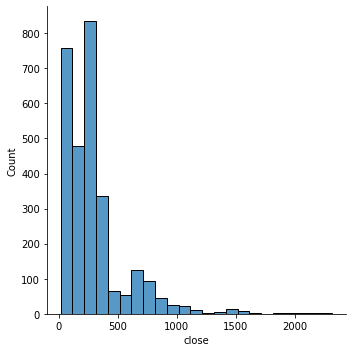

In [10]:
sns.displot(clean_data['close'], binwidth = 100)

**Skewed to the right**

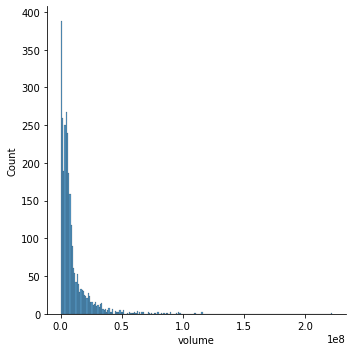

In [11]:
 sns.displot(clean_data['volume'], binwidth = 1000500)

**Skewed to the right**

In [12]:
def get_moving_average(data,years) -> pd.DataFrame():
  moving_avg = []
  start = '{}-01-01'
  end = '{}-12-31'
  for year in years:
    yearly_data = data.loc[start.format(str(year)):end.format(str(year))]
    moving_avg.append(yearly_data['close'].mean())

  return pd.DataFrame(moving_avg, index = years, columns = ['Moving AVG'])

In [13]:
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
yearly_moving_avg = get_moving_average(clean_data,years)
yearly_moving_avg

,Moving AVG
2010,23.341723
2011,26.804710
2012,31.168693
2013,104.401367
2014,223.329056
2015,230.042738
2016,209.767262
2017,314.315677
2018,317.309920
2019,273.530198


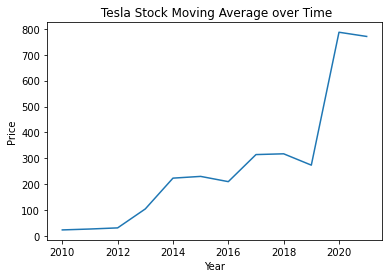

In [14]:
plt.plot(years,yearly_moving_avg['Moving AVG'])
plt.title(' Tesla Stock Moving Average over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

**Observations**

- Gradual increase from 2010 -2014 
- Stagnation from 2014-2019 with slight increase
- Huge spike from 2019-2020

In [17]:
 #Do correlation matrix btw all varibles 
def get_average_volume(data,years) -> pd.DataFrame():
  volume_avg = []
  start = '{}-01-01'
  end = '{}-12-31'
  for year in years:
    yearly_data = data.loc[start.format(str(year)):end.format(str(year))]
    volume_avg.append(yearly_data['volume'].mean())

  return pd.DataFrame(volume_avg, index = years, columns = ['Volume AVG'])

yearly_vol_avg = get_average_volume(clean_data,years)
yearly_vol_avg

,Volume AVG
2010,1.579762e+06
2011,1.290615e+06
2012,1.229796e+06
2013,8.407722e+06
2014,6.913344e+06
2015,4.312335e+06
2016,4.611938e+06
2017,6.269647e+06
2018,8.591000e+06
2019,9.158555e+06


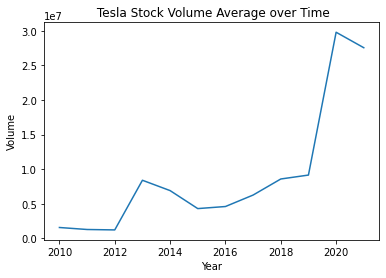

In [18]:
plt.plot(years,yearly_vol_avg['Volume AVG'])
plt.title(' Tesla Stock Volume Average over Time')
plt.xlabel('Year')
plt.ylabel('Volume')
plt.show()

**Observations**

- Shape increase from 2012-2013
- Decreasing 2013- 2015
- Gradual inc. 2015-2019
- Very dramatic increase from 2019-2020

Text(0.5, 1.0, 'Attribute Correlation')

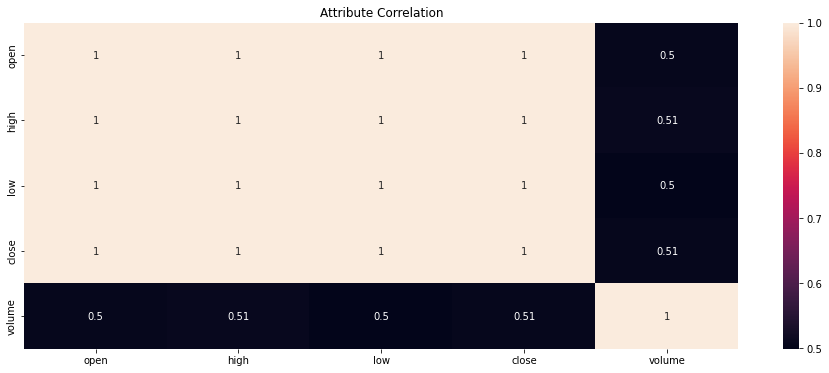

In [19]:
plt.figure(figsize=(16,6))
corr_heatmap = sns.heatmap(clean_data.corr(), annot = True)
corr_heatmap.set_title('Attribute Correlation')

**Volume closely correlated with closing price**